---
title: "算法交易：制胜策略与原理(欧内斯特·陈)之六"
description: 日间动量型交易策略
author: 王一刀
categories: [算法交易]
date: 2024-09-05
format: html
---

日间动量型交易策略之所以存在的主要原因有四个：
* （1）对期货而言，连续收益率具有可持续性，尤其是它们所显现的迹象。
* （2）一个新的信息要经历缓慢的扩散、分析和接受三个过程。
* （3）由各种类型的基金所构成的资产经常被迫出售或购回。
* （4）金融市场往往被高频交易员所操纵。
研究人员有时将资产价格所显现的动量模式分为两种类型，即时间序列动量和横向动量.

时间序列型动量模式非常简单和直观：过往价格系列的收益率与未来的收益呈正相关性；横向动量是指某种金融工具的价格系列相对于其他工具的价格系列的相对性——当某种价格系列的收益胜过其他系列的收益，那么，此种势头将来可能会被延续，反之亦然。

### 时间序列型交易策略

我们应该分别找到最优化的过去和未来的时间序列，从而使其之间的相应收益率呈现最高的正相关性，然后，将其设置为回溯期与持单（仓）期，进而检验相应的动量交易策略。

如果我们感兴趣的是探寻是否存在一种具有长期趋势之行情的时间序列，而不考虑特定的时间框架，那我们就可以计算赫斯特指数，同时，以方差比率的检验模式排除随机漫步的零假设，这个在第2章中已被描述的测试模式是用于检测均值回归交易策略的，但它们也可以用于测试动量型的交易策略。



   1    1 -0.0576  0.0100
   1    5 -0.0769  0.0006
   1   10 -0.0274  0.2230
   1   25 -0.0139  0.5385
   1   60  0.0326  0.1583
   1  120  0.0195  0.4137
   1  250  0.0361  0.1626
   5    1 -0.0756  0.0007
   5    5 -0.1271  0.0111
   5   10 -0.0472  0.3485
   5   25  0.0323  0.5245
   5   60  0.0860  0.0958
   5  120  0.0514  0.3361
   5  250  0.0943  0.1032
  10    1 -0.0280  0.2118
  10    5 -0.0485  0.3348
  10   10  0.0366  0.6087
  10   25  0.1162  0.1058
  10   60  0.1804  0.0132
  10  120  0.0929  0.2200
  10  250  0.1651  0.0434
  25    1 -0.0140  0.5353
  25    5  0.0319  0.5276
  25   10  0.1513  0.0343
  25   25  0.1955  0.0863
  25   60  0.2361  0.0414
  25  120  0.1692  0.1584
  25  250  0.2470  0.0571
  60    1  0.0313  0.1686
  60    5  0.0799  0.1168
  60   10  0.1718  0.0169
  60   25  0.1850  0.1095
  60   60  0.2162  0.2346
  60  120 -0.0087  0.9635
  60  250  0.2971  0.1492
 120    1  0.0222  0.3355
 120    5  0.0565  0.2750
 120   10  0.0955  0.1934
 120   25  0

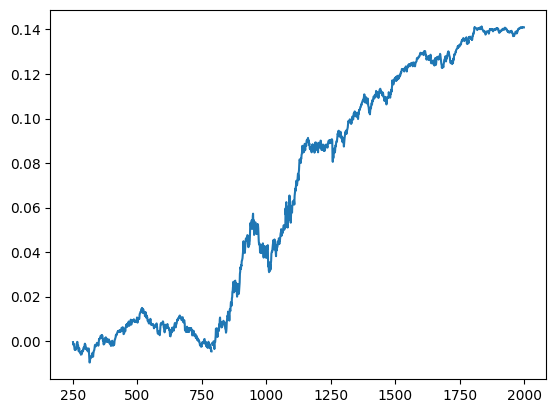

In [12]:
# Box 6.1 and Example 6.1: Finding Correlations between Returns of Different Time Frames
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm
from scipy.stats import pearsonr

# 用于计算最大回撤（Maximum Drawdown）和最大回撤持续时间（Maximum Drawdown Duration）
def calculateMaxDD(cumret):
# =============================================================================
# calculation of maximum drawdown and maximum drawdown duration based on
# cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
# i is the index of the day with maxDD.
# =============================================================================
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
             
    maxDD, i=np.min(drawdown), np.argmin(drawdown) # drawdown < 0 always
    maxDDD=np.max(drawdownduration)
    return maxDD, maxDDD, i

df=pd.read_csv('datas/inputDataOHLCDaily_TU_20120511.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)
# 计算不同时间框架下的收益率相关性：
for lookback in [1, 5, 10, 25, 60, 120, 250]:
    for holddays in [1, 5, 10, 25, 60, 120, 250]:
        ret_lag=df.pct_change(periods=lookback)
        ret_fut=df.shift(-holddays).pct_change(periods=holddays,fill_method=None)
        if (lookback >= holddays):
            indepSet=range(0, ret_lag.shape[0], holddays)
        else:
            indepSet=range(0, ret_lag.shape[0], lookback)
            
        ret_lag=ret_lag.iloc[indepSet]
        ret_fut=ret_fut.iloc[indepSet]
        # 确保 ret_lag 和 ret_fut 是 pandas Series
        ret_lag = ret_lag.squeeze()  # 将 DataFrame 转换为 Series
        ret_fut = ret_fut.squeeze()  # 将 DataFrame 转换为 Series
        goodDates=(ret_lag.notna() & ret_fut.notna()).values
        (cc, pval)=pearsonr(ret_lag[goodDates], ret_fut[goodDates])
        print('%4i %4i %7.4f %7.4f' % (lookback, holddays, cc, pval))

lookback=250
holddays=25

longs=df > df.shift(lookback)
shorts=df < df.shift(lookback)

pos=np.zeros(df.shape)
pd.set_option('future.no_silent_downcasting', True)
for h in range(holddays-1):
    long_lag=longs.shift(h).fillna(False).astype(bool)
    short_lag=shorts.shift(h).fillna(False).astype(bool)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))

如果期货的总收益率=现货收益率+连续收益率，那么，提取连续收益的一个明显的方法是：如果连续收益率是负值（例如，在期货溢价的情境之下），那我们就购买标的资产，同时做空期货；如果连续收益率是正值（即在现货溢价的情境之下），那我们就进行反向操作，此种模式可一直延续至连续收益率相关的信号迹象之变化趋缓，如往常一样之时。

如果我们想要提取连续收益，VX期货是一种很自然的选择：此期货的年化连续收益率可以低至-50%；与此同时，其与ES期货具有强烈的反关联性，两者天收益率之间的相关系数达到-75%。在第5章中，我们使用了VX期货和ES期货之间的协整关系，开发了一个有利可图的均值回归策略。在这里，我们将利用VX期货较大幅度的连续收益率的变化，同时，依据ES期货较小幅度的连续收益率的变化，并且，根据两者的反相关性，进而开发相关的动量交易策略。


APR=0.377914 Sharpe=2.117500
Max DD=-0.434420 Max DDD in days=73


C:\Users\win10\AppData\Local\Temp\ipykernel_4936\1180818726.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
C:\Users\win10\AppData\Local\Temp\ipykernel_4936\1180818726.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1


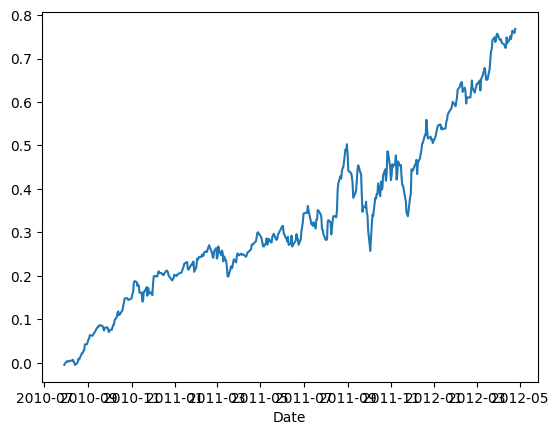

In [16]:
# Volatility Futures vs Equity Index Futures

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

entryThreshold=0.1
onewaytcost=1/10000

# VX futures
vx=pd.read_csv('datas/inputDataDaily_VX_20120507.csv')
vx['Date']=pd.to_datetime(vx['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
vx.set_index('Date', inplace=True)

# VIX index
vix=pd.read_csv('datas/VIX.csv')
vix['Date']=pd.to_datetime(vix['Date'],  format='%Y-%m-%d').dt.date # remove HH:MM:SS
vix.set_index('Date', inplace=True)
vix=vix[['Close']]
vix.rename({'Close': 'VIX'}, axis=1, inplace=True)


# ES backadjusted continuous contract
es=pd.read_csv('datas/inputDataDaily_ES_20120507.csv')
es['Date']=pd.to_datetime(es['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
es.set_index('Date', inplace=True)
es.rename({'Close': 'ES'}, axis=1, inplace=True)

# Merge on common dates
df=pd.merge(vx, vix, how='inner', on='Date')
df=pd.merge(df, es, how='inner', on='Date')

vx=df.drop({'VIX', 'ES'}, axis=1)
vix=df[['VIX']]
es=df[['ES']]

isExpireDate=vx.notnull() & vx.shift(-1).isnull()

# Define front month as 40 days to 10 days before expiration
numDaysStart=40
numDaysEnd=10

positions=np.zeros((vx.shape[0], vx.shape[1]+1))

for c in range(vx.shape[1]-1):
    expireIdx=np.where(isExpireDate.iloc[:,c])
    if c==0:
        startIdx=expireIdx[0]-numDaysStart
        endIdx=expireIdx[0]-numDaysEnd
    else:
        startIdx=np.max((endIdx+1, expireIdx[0]-numDaysStart))
        endIdx=expireIdx[0]-numDaysEnd
        
    if (expireIdx[0] >= 0):
        # startIdx = int(startIdx[0])
        # endIdx = int(endIdx[0])
        
        if(isinstance(startIdx, np.ndarray)):
            intStartIdx = startIdx[0]
        else:
            intStartIdx = startIdx

        if(isinstance(endIdx, np.ndarray)):
            intEndIdx = endIdx[0]
        else:
            intEndIdx = endIdx
        idx=np.arange(intStartIdx, intEndIdx+1)
        # print(expireIdx)
        # expireIdx = int(expireIdx[0])
        # print(expireIdx[0][0])
        # print(type(expireIdx))
        # temp = np.arange(expireIdx[0][0]-intStartIdx+1, expireIdx[0][0]-intEndIdx, -1)
        dailyRoll=(vx.iloc[idx, c]-vix.iloc[idx, 0])/np.arange(expireIdx[0][0]-intStartIdx+1, expireIdx[0][0]-intEndIdx, -1)
        positions[idx[dailyRoll > entryThreshold], c]=-1
        positions[idx[dailyRoll > entryThreshold], -1]=-1
        
        positions[idx[dailyRoll < -entryThreshold], c]=1
        positions[idx[dailyRoll < entryThreshold], -1]=1

y=pd.merge(vx*1000, es*50, on='Date')
positions=pd.DataFrame(positions, index=y.index)
pnl=np.sum((positions.shift().values)*(y-y.shift()) - onewaytcost*np.abs(positions.values*y - (positions.values*y).shift()), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs((positions.values*y).shift()), axis=1)

idx=ret.index[ret.index >= pd.to_datetime("2008-08-04").date()]
cumret=(np.cumprod(1+ret[idx[500:]])-1)
cumret.plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret[idx[500:]])**(252/len(ret[idx[500:]]))-1, np.sqrt(252)*np.mean(ret[idx[500:]])/np.std(ret[idx[500:]])))
# from calculateMaxDD import calculateMaxDD
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
#APR=0.377914 Sharpe=2.117500
#Max DD=-0.434420 Max DDD in days=73

### 横向型动量交易策略
除了购买和持有，或相对于标的资产（或凭借与标的资产具有相关性的金融工具）所进行的套利交易之外，还有第三种方法可以从期货当中提取高额连续收益。这第三条路径是一个跨部门的横向型交易策略，即**我们可以在现货溢价的情境之下，买入一个期货的投资组合，同时，在期货溢价的状况之下，做空相关期货的投资组合，如此则有希望将相应现货价格的收益率进行彼此的抵消［如果我们相信大宗商品的现货价格与经济增长，或其他宏观经济指标呈正相关性，那么，此种期望就不是不合理的］，这样的话，抵消之后所遗留的就是连续收益了**。丹尼尔和莫斯科维茨描述了这样一个简单的“横向型”动量交易策略，它几乎就是汉丹和罗在第3章所述的线性多空股票均值回归模型的一个镜像，只不过，本章的策略有更长的回溯期和持单期（丹尼尔和莫斯科维茨，2011）。


丹尼尔和莫斯科维茨也发现上述策略适用于世界性的股票指数期货、货币交易、国际股市和美国股市。换句话说，几乎一切在阳光下的金融交易均可适用于此策略。很明显，在货币交易和股票交易中，横向型动量交易策略已不再被解释成连续收益率相关的具有持久性的行情趋势。而我们可能掌握的序列相关属性是：在货币交易中，世界经济和利率增长与其具有相关性，而在股票交易中，一个新的信息要经历缓慢扩散、分析和接受三个过程。

上述这种策略如果应用到美国股市的话，我们可以如此操作：购买和持有12个月展期收益率排在前10的股票，持有期限为一个月，而对于最差的10只股票，我们则可进行反向操作，


APR=-0.003019 Sharpe=-0.286628


C:\Users\win10\AppData\Roaming\Python\Python39\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\win10\AppData\Roaming\Python\Python39\site-packages\numpy\_core\fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\win10\AppData\Local\Temp\ipykernel_4936\4244792157.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1,

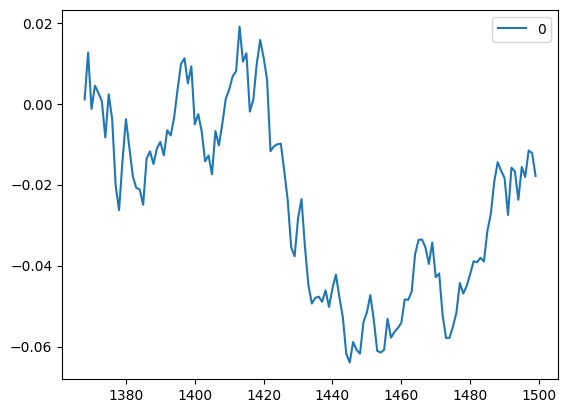

In [18]:
# Example 6.2: Cross-Sectional Momentum Strategy for Stocks

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

lookback=252
holddays=25
topN=50

# Stocks
cl=pd.read_csv('datas/inputDataOHLCDaily_20120424_cl.csv')
stocks=pd.read_csv('datas/inputDataOHLCDaily_20120424_stocks.csv')

cl['Var1']=pd.to_datetime(cl['Var1'],  format='%Y%m%d').dt.date # remove HH:MM:SS
cl.columns=np.insert(stocks.values, 0, 'Date')
cl.set_index('Date', inplace=True)

ret=cl.pct_change(periods=lookback)
longs=np.full(cl.shape, False)
shorts=np.full(cl.shape, False)
positions=np.zeros(cl.shape)

for t in range(lookback, cl.shape[0]):
    hasData=np.where(np.isfinite(ret.iloc[t, :]))
    hasData=hasData[0]
    if len(hasData)>0:
        idxSort=np.argsort(ret.iloc[t, hasData])  
        longs[t, hasData[idxSort.values[np.arange(-np.min((topN, len(idxSort))),0)]]]=1
        shorts[t, hasData[idxSort.values[np.arange(0,topN)]]]=1
        
longs=pd.DataFrame(longs)
shorts=pd.DataFrame(shorts)

for h in range(holddays-1):
    long_lag=longs.shift(h).fillna(False).astype(bool)
    short_lag=shorts.shift(h).fillna(False).astype(bool)
    positions[long_lag]=positions[long_lag]+1
    positions[short_lag]=positions[short_lag]-1
    
positions=pd.DataFrame(positions)
ret=pd.DataFrame(np.sum((positions.shift().values)*(cl.pct_change().values), axis=1)/(2*topN)/holddays) # daily P&L of the strategy
cumret=(np.cumprod(1+ret)-1)
cumret.plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret,axis=0)/np.std(ret)))
#from calculateMaxDD import calculateMaxDD
#maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
#print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))

由股票所构成的跨行业的横向投资组合，无论是基于均值回归策略，还是动量交易策略，都会排除相关成分股的市值收益，而相应总收益就只有靠要素生成了。至于相关要素，其可以由基本面分析所产生，例如，相关企业的收益增长率、相关股票的市净率，以及一些线性组合因素等。同时，相关要素还可能是一些统计因子，例如《量化交易》（Quantitative Trading）（陈，2009）里的“资本成分分析”（PAC）一节当中所涉及的因子，除却这些因子以外，前述各类要素的变化很慢，所以，以此类因素为股票排序的话，相应效能的展示时间亦会很长，其跨度基本与本节中所描述的第一种类型的横向型动量交易模式中的持单期限一样。


## 盘中动量型交易策略
我们看到大多数的金融工具，无论是股票还是期货，大都表现出横向型的动量模式，同时也经常呈现时间序列的性质。但不幸的是，这种动量行为模式的时间周期往往是一个月或更长的时间。而较长的持有期存在两个问题，即从统计学意义的回测程序上看，其所导致的夏普比率比较低，这主要是因为其间的独立交易信号比较罕见，进而在财政危机发生之后，相应的交易模式就会表现不佳。

盘中动量交易策略可以触发的特定事件不仅仅是价格的运行模式，相关事件还包括诸如盈利公告之类的企业信息，或者分析师的更改建议，以及宏观经济新闻等，这些事件所生成的时间序列型动量交易策略早已为人所知，但是现在，我要对每个特定类别事件的影响做一些新的研究。

### “敞口”交易策略
在第4章中，我们讨论了一个缺口买入型的、股票相关的均值回归策略，而于同等情境之下，动量型策略在操作期货和货币交易之时，其运行模式正好相反，即当相关金融工具的价格向上跳开时做多，而在其向下跳开时做空。


APR=0.074864 Sharpe=0.494857
Max DD=-0.233629 Max DDD in days=789


C:\Users\win10\AppData\Local\Temp\ipykernel_4936\1180818726.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
C:\Users\win10\AppData\Local\Temp\ipykernel_4936\1180818726.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1


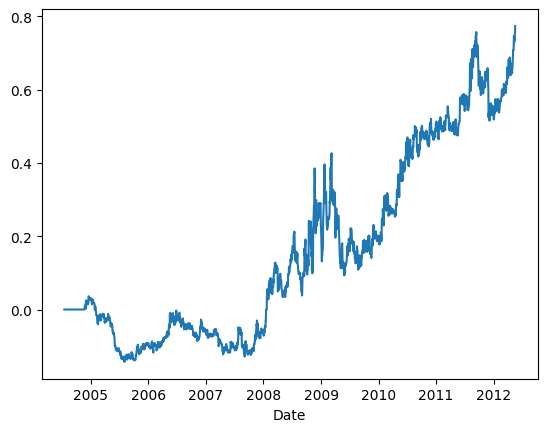

In [19]:
# Example 7.1: Opening Gap Strategy for FSTX

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

entryZscore=0.1


df=pd.read_csv('datas/inputDataDaily_FSTX_20120517.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

stdretC2C90d=df['Close'].pct_change().rolling(90).std().shift()

longs= df['Open'] >= df['High'].shift()*(1+entryZscore*stdretC2C90d)
shorts=df['Open'] >= df['Low'].shift()*(1-entryZscore*stdretC2C90d)

positions=np.zeros(longs.shape)

positions[longs]=1
positions[shorts]=-1

ret=positions*(df['Close']-df['Open'])/df['Open']

cumret=(np.cumprod(1+ret)-1)
cumret.plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
# from calculateMaxDD import calculateMaxDD
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
#APR=0.074864 Sharpe=0.494857
#Max DD=-0.233629 Max DDD in days=789

### 信息驱动的动量交易策略
正如许多人认为的那样：价格的动量运行模式是由缓慢扩散的新闻事件所导致的。当然，我们可以在一个有新闻价值的事件之后的前几天、几小时甚至几秒之后有所受益，这就是传统的财报收益报告公布之后的行情漂移的基本原理模型（post-earnings announcement drift models，PEAD模型）；同时，还有一些其他的模型，它们大都基于不同企业或宏观经济新闻等因素来生成相应的动量运行模式。

如果在前一个交易日收盘之后，股票相关企业公布其收益报告，我们于第二个交易日的开盘时刻入场——如果相关收益率为正，我们就做多该股票；如果相应收益率为负，我们就做空该股票，同时，在当天清算所有头寸，那么，这个交易策略仍然是有利可图的。这里需要注意的是：这种策略不需要交易员解释收益报告是“好”还是“坏”，甚至不要求交易员知道相应收益是否高于或低于分析师的预期，我们可以让市场行情告诉自己相应的收益是好还是坏。



APR=0.068126 Sharpe=1.494743
Max DD=-0.026052 Max DDD in days=109


C:\Users\win10\AppData\Local\Temp\ipykernel_4936\1180818726.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
C:\Users\win10\AppData\Local\Temp\ipykernel_4936\1180818726.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1


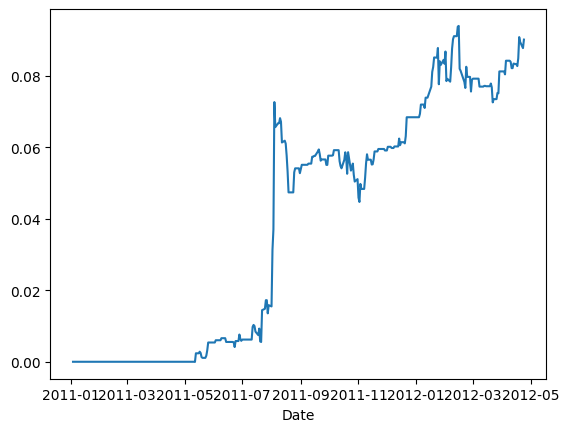

In [21]:
# Example 4.1: Buy-on-Gap Model on SPX Stocks

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

op=pd.read_csv('datas/inputDataOHLCDaily_20120424_op.csv')
cl=pd.read_csv('datas/inputDataOHLCDaily_20120424_cl.csv')

stocks=pd.read_csv('datas/inputDataOHLCDaily_20120424_stocks.csv')

op['Var1']=pd.to_datetime(op['Var1'],  format='%Y%m%d').dt.date # remove HH:MM:SS
op.columns=np.insert(stocks.values, 0, 'Date')
op.set_index('Date', inplace=True)

cl['Var1']=pd.to_datetime(cl['Var1'],  format='%Y%m%d').dt.date # remove HH:MM:SS
cl.columns=np.insert(stocks.values, 0, 'Date')
cl.set_index('Date', inplace=True)

earnann=pd.read_csv('datas/earnannFile.csv')
earnann['Date']=pd.to_datetime(earnann['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
earnann.set_index('Date', inplace=True)

np.testing.assert_array_equal(stocks.iloc[0,:], earnann.columns)

df=pd.merge(op, cl, how='inner', left_index=True, right_index=True, suffixes=('_op', '_cl'))
df=pd.merge(earnann, df, how='inner', left_index=True, right_index=True)

earnann=df.iloc[:, 0:(earnann.shape[1])].astype(bool)
op=df.iloc[:, (earnann.shape[1]):((earnann.shape[1])+op.shape[1])]
cl=df.iloc[:, ((earnann.shape[1])+op.shape[1]):]

op.columns=stocks.iloc[0,:]
cl.columns=stocks.iloc[0,:]

lookback=90

retC2O=(op-cl.shift())/cl.shift()
stdC2O=retC2O.rolling(lookback).std()

positions=np.zeros(cl.shape) 

longs=  (retC2O >=  0.5*stdC2O) & earnann
shorts= (retC2O <= -0.5*stdC2O) & earnann

positions[longs]=1
positions[shorts]=-1

ret=np.sum(positions*(cl-op)/op, axis=1)/30

cumret=(np.cumprod(1+ret)-1)
cumret.plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
# from calculateMaxDD import calculateMaxDD
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
#APR=0.068126 Sharpe=1.494743
#Max DD=-0.026052 Max DDD in days=109

我们在均值回归策略所相关的例5-1中，对蒙特卡罗技术进行了详细的解析。但首先，我们依据测试集中的天收益率就会很容易地计算出相应的凯利杠杆比例是18.4；我们应该记住这个数字，且与蒙特卡罗模拟的测试结果进行比较；接下来，我们基于相应日收益率所相关的初始四个阶矩来构造一个皮尔逊系统，并在系统中生成100000个随机收益率的数值


skew=0.122820 loc=0.000432 scale=0.004231
mean=0.000432 var=0.000018 skew=0.122820 kurt=0.022627
Optimal leverage=25.512625 optimal growth rate=0.005767
minR=-0.018201
Max DD=-0.996312 with optimal leverage=25.512625
Max DD=-0.900276 with half optimal leverage=12.756313
Max DD=-0.429629 with half optimal leverage=3.644661
Max DD=-0.625894 with historical returns=18.223304
Growth rate on simulated returns using D=0.5 of optimal leverage on full account=0.004317
MaxDD on simulated returns using D of optimal leverage on full account=-0.900276
Growth rate on simulated returns using CPPI=0.004264
Growth rate on historical returns using D of optimal leverage on full account=0.004053
MaxDD on historical returns using D of optimal leverage on full account=-0.482626


C:\Users\win10\AppData\Local\Temp\ipykernel_4936\158564989.py:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Growth rate on historical returns using D of optimal leverage on full account=%f' % (-minusG(optimalF*D)))
C:\Users\win10\AppData\Local\Temp\ipykernel_4936\158564989.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drawdown=np.min([0, ((1+drawdown)*(1+df.iloc[t,])-1)[0]])


Growth rate on historical returns CPPI=0.003991


C:\Users\win10\AppData\Local\Temp\ipykernel_4936\158564989.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Growth rate on historical returns CPPI=%f' % (g_cppi))


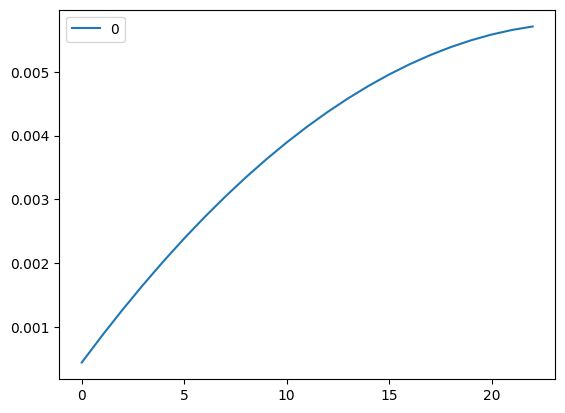

In [25]:
# Box 8.1
import numpy as np
import pandas as pd
#from scipy.stats import describe 
from scipy.stats import pearson3
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm
from scipy.optimize import minimize
 
df=pd.read_csv('datas/AUDCAD_unequal_ret.csv')
# 使用pearson3函数拟合数据，并计算了数据的偏度、位置和尺度参数
skew_, loc_, scale_=pearson3.fit(df) 
print('skew=%f loc=%f scale=%f' % (skew_, loc_, scale_))
mean,var,skew,kurt=pearson3.stats(skew_, loc_, scale_, moments='mvks')
print('mean=%f var=%f skew=%f kurt=%f' % (mean, var, skew, kurt))
# 使用拟合得到的参数生成了100,000个模拟收益率
ret_sim=pearson3.rvs(skew_, loc_, scale_, size=100000, random_state=0)
# 定义了一个函数g，用于计算给定收益率和杠杆率的增长率
def g(f, R):
    return np.sum(np.log(1+f*R), axis=0)/R.shape[0]
# 对于不同的杠杆率（从1到23），计算了模拟收益率的增长率，并绘制了图表
myf=range(1, 24)
myg=np.full(24, np.nan)

for f in myf:
    myg[f]=g(f, ret_sim)

myg=myg[1:]
myg=pd.DataFrame(myg)
myg.plot()
# 定义了一个最小化函数minusG和minusGsim，用于找到最优的杠杆率
minusG = lambda f : -g(f, df)
minusGsim = lambda f : -g(f, ret_sim)
# 使用minimize函数找到了最优的杠杆率和对应的最大增长率
#optimal leverage based on simulated returns
res = minimize(minusGsim, 0, method='Nelder-Mead')
optimalF=res.x
print('Optimal leverage=%f optimal growth rate=%f' % (optimalF[0], -res.fun))
#Optimal leverage=25.512625 optimal growth rate=0.005767

minR=np.min(ret_sim)
print('minR=%f' % (minR))
#minR=-0.018201

# max drawdown with optimal leverage
# from calculateMaxDD import calculateMaxDD
maxDD, maxDDD, i=calculateMaxDD((np.cumprod(1+optimalF*ret_sim)-1))
print('Max DD=%f with optimal leverage=%f' % (maxDD, optimalF[0]))
#Max DD=-0.996312 with optimal leverage=25.512625

#max drawdown with half of optimal leverage
maxDD, maxDDD, i=calculateMaxDD((np.cumprod(1+optimalF/2*ret_sim)-1))
print('Max DD=%f with half optimal leverage=%f' % (maxDD, optimalF[0]/2))
#Max DD=-0.900276 with half optimal leverage=12.756313

# max drawdown with 1/7 of optimal leverage
maxDD, maxDDD, i=calculateMaxDD((np.cumprod(1+optimalF/7*ret_sim)-1))
print('Max DD=%f with half optimal leverage=%f' % (maxDD, optimalF[0]/7))
#Max DD=-0.429629 with half optimal leverage=3.644661

#max drawdown with 1/1.4 of optimal leverage for historical returns
maxDD, maxDDD, i=calculateMaxDD((np.cumprod(1+optimalF/1.4*df.values)-1))
print('Max DD=%f with historical returns=%f' % (maxDD, optimalF[0]/1.4))
#Max DD=-0.625894 with historical returns=18.223304

D=0.5
print('Growth rate on simulated returns using D=%3.1f of optimal leverage on full account=%f' % (D, -minusGsim(optimalF*D)))
#Growth rate on simulated returns using D=0.5 of optimal leverage on full account=0.004317
maxDD, maxDDD, i=calculateMaxDD((np.cumprod(1+optimalF*D*ret_sim)-1))
print('MaxDD on simulated returns using D of optimal leverage on full account=%f' % (maxDD))
#MaxDD on simulated returns using D of optimal leverage on full account=-0.900276
# 使用CPPI策略计算了模拟收益率和历史收益率的增长率和最大回撤
# CPPI
g_cppi=0
drawdown=0
for t in range(ret_sim.shape[0]):
    g_cppi+=np.log(1+ret_sim[t]*D*optimalF*(1+drawdown))
    drawdown=min([0, (1+drawdown)*(1+ret_sim[t])-1])
    
g_cppi=g_cppi/len(ret_sim)
print('Growth rate on simulated returns using CPPI=%f' % g_cppi[0])
#Growth rate on simulated returns using CPPI=0.004264
print('Growth rate on historical returns using D of optimal leverage on full account=%f' % (-minusG(optimalF*D)))
#Growth rate on historical returns using D of optimal leverage on full account=0.004053
maxDD, maxDDD, i=calculateMaxDD((np.cumprod(1+optimalF*D*df.values)-1))
print('MaxDD on historical returns using D of optimal leverage on full account=%f' % (maxDD))
#MaxDD on historical returns using D of optimal leverage on full account=-0.303448

# CPPI
g_cppi=0
drawdown=0
for t in range(df.shape[0]):
    g_cppi+=np.log(1+df.iloc[t,]*D*optimalF*(1+drawdown))
    # print("=========")
    # print(type((1+drawdown)*(1+df.iloc[t,])-1))
    # print((1+drawdown)*(1+df.iloc[t,])-1)
    # print(((1+drawdown)*(1+df.iloc[t,])-1)[0])
    # print("=========")
    drawdown=np.min([0, ((1+drawdown)*(1+df.iloc[t,])-1)[0]])
    
g_cppi=g_cppi/len(df)
print('Growth rate on historical returns CPPI=%f' % (g_cppi))


CPPI（Constant Proportion Portfolio Insurance）策略，即恒定比例投资组合保险策略，是一种投资组合管理技术，主要用于风险管理和资产配置。CPPI策略的核心思想是通过动态调整风险资产（如股票、期货等）和安全资产（如债券、现金等）的比例，以保证投资组合在特定时间段内的最低价值。

CPPI策略的基本原理如下：

1. **确定保本额**：投资者首先确定一个保本额，即在投资期末希望至少能够收回的金额。

2. **计算安全垫**：安全垫是指投资组合当前价值与保本额之间的差额。安全垫的大小决定了可以投资于风险资产的最大金额。

3. **确定风险乘数**：风险乘数是一个系数，用于确定投资于风险资产的金额。风险乘数的大小取决于投资者的风险承受能力和投资目标。

4. **动态调整资产配置**：根据市场情况和投资组合的表现，定期调整风险资产和安全资产的比例。当投资组合价值上升时，可以增加对风险资产的投资；当投资组合价值下降时，减少对风险资产的投资，以保证投资组合的价值不低于保本额。

CPPI策略的优点：

1. **保本性**：通过设定保本额和安全垫，CPPI策略能够在投资期末保证投资者至少能够收回保本额。

2. **灵活性**：CPPI策略可以根据市场情况和投资者的风险承受能力动态调整资产配置，以实现最佳的风险收益平衡。

3. **简单易行**：CPPI策略的计算方法相对简单，易于理解和实施。

然而，CPPI策略也存在一定的缺点：

1. **市场风险**：尽管CPPI策略能够在一定程度上降低市场风险，但在极端市场情况下，如市场大幅下跌，投资组合的价值仍可能低于保本额。

2. **机会成本**：为了保证投资组合的保本性，投资者可能需要放弃部分潜在的高收益机会。

总之，CPPI策略是一种适用于风险厌恶型投资者的投资组合管理技术，通过动态调整资产配置，可以在保证投资组合保本性的同时，追求一定的投资收益。